### Clouds : test clouds 3D with NEXT MC events

G. Díaz, J. A Hernando


May 2021

In [1]:
#%matplotlib inline 

%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
#import hipy.hfit         as hfit

import clouds.clouds    as clouds
import clouds.graphs    as graphs
import clouds.pltclouds as pltclouds

import clouds.mc_clouds as mcclouds

#import bes.bes           as bes
#import bes.clouds        as clouds
#import next.reco.chits      as chits
#import next.reco.display    as nplay


In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed May 12 19:04:43 2021


In [5]:
#import os
import re
import glob
#import numpy  as np
#import pandas as pd
#import tables as tb

#import matplotlib
#from matplotlib import cm
#from matplotlib import pyplot as plt

#import clouds
#import pltclouds

In [6]:
get_file_number = lambda filename: int(re.findall("_[0-9]+_", filename)[0][1:-1])

def split_hits(hitsdf, weight="E"):
    
    xyz = hitsdf[["X", "Y", "Z"]].values
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    w = hitsdf[weight].values
    
    return x, y, z, w

# ojo
#fname = '/home/hernando/data/NEW/MC/bb0nu_esmeralda/map_8264.h5'
fname = '/Users/hernando/investigacion/NEXT/data/MC/NEW/bb0nu_esmeralda/map_8264.h5'
maps_te = pd.read_hdf(fname, "time_evolution")
dv = maps_te.dv.mean()

In [7]:
#datadir   = "/home/hernando/data/NEW/MC/bb0nu_esmeralda/"
datadir   = "/Users/hernando/investigacion/NEXT/data/MC/NEW/bb0nu_esmeralda/"
files     = glob.glob(datadir + '*.h5')
def file_number(file):
    fname = file .split('/')[-1]
    ifile = fname.split('_')[1]
    return str(ifile)
#print(files)
filenames = sorted(files, key = file_number)
print('total files', len(filenames), get_file_number(filenames[1]))

total files 501 1


In [8]:
#filename = np.random.choice(filenames)
#print(filename)
#filename = '/home/hernando/data/NEW/MC/bb0nu_esmeralda/esmeralda_321_0nubb.h5'
#print("File number", get_file_number(filename))

In [9]:
# events good:  3214
# File number 125 , Event 1252
# filename, event  =  360 ,  3604
# filename, event  =  379 ,  3798
# filename, event  =  25 ,  256


# interesing problematic events
# filename, event  =  190 ,  1902

# Interesting events
# filename, event  =  490 ,  4901
# filename, event  =  449 ,  4493



In [10]:
def get_event(filename = None, event = None):
    filename = np.random.choice(filenames) if filename is None else filename

    CHITS_lowTh  = pd.read_hdf(filename, "/CHITS/lowTh") .groupby("event")
    CHITS_highTh = pd.read_hdf(filename, "/CHITS/highTh").groupby("event")

    MChits = pd.read_hdf(filename, "MC/hits").groupby("event_id")
    data_events = pd.read_hdf(filename, "Run/events")
    event       = np.random.choice(data_events["evt_number"]) if event is None else event
    print('filename, event  = ', get_file_number(filename), ', ', event)
    
    low  = CHITS_lowTh .get_group(event)
    high = CHITS_highTh.get_group(event)
    true = MChits      .get_group(event)

    x, y, z, w = split_hits(low, weight="E")
    coors = (x, y, z)
    ene   = 1e-5 * w

    mcx, mcy, mcz = true["x"].values, true["y"].values, dv*true["z"].values
    mccoors = (mcx, mcy, mcz)
    mcene, mctime = true["energy"].values, true['time'].values
    
    print('Energy MC ', np.sum(mcene), ', RC ', np.sum(ene))
    
    if (np.sum(ene) <= 2.1): 
        return get_event()
    
    return coors, ene, mccoors, mcene, mctime 
    

In [11]:
coors, ene, mccoors, mcene, mctime = get_event()

filename, event  =  491 ,  4914
Energy MC  1.6995356 , RC  1.5693537453460693
filename, event  =  252 ,  2527
Energy MC  1.606552 , RC  1.386738147470951
filename, event  =  109 ,  1099
Energy MC  2.1964893 , RC  2.034647631711485
filename, event  =  58 ,  583
Energy MC  2.1557078 , RC  1.7943439447784426
filename, event  =  399 ,  3992
Energy MC  2.4578302 , RC  2.3834629714012148


## Draw MC event

<IPython.core.display.Javascript object>


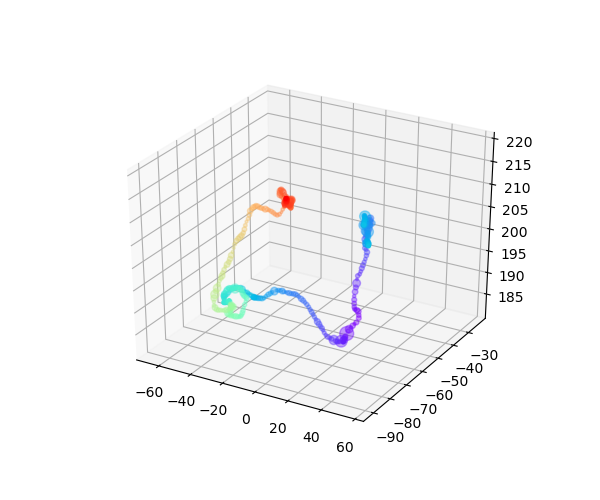

In [12]:
subplot = pltext.canvas(1, 1)
plt.gcf().add_subplot(1, 1 ,1, projection = '3d')
scale  = mctime/np.max(mctime)
size   = mcene/np.max(mcene)
p = plt.gca().scatter(*mccoors, c = scale , s = 100 * size, marker = 'o', alpha = 0.4);

In [13]:
#pltclouds.plot_tview(mccoors, mcene, mctime)

## Draw Reco

In [14]:
steps  = (10, 10, 2)
bins, mask, cells, df = clouds.clouds(coors, steps, ene)

In [15]:
#steps  = (2, 2, 2)
#bins, mask, cells, df = clouds.clouds(mccoors, steps, mcene)

<IPython.core.display.Javascript object>


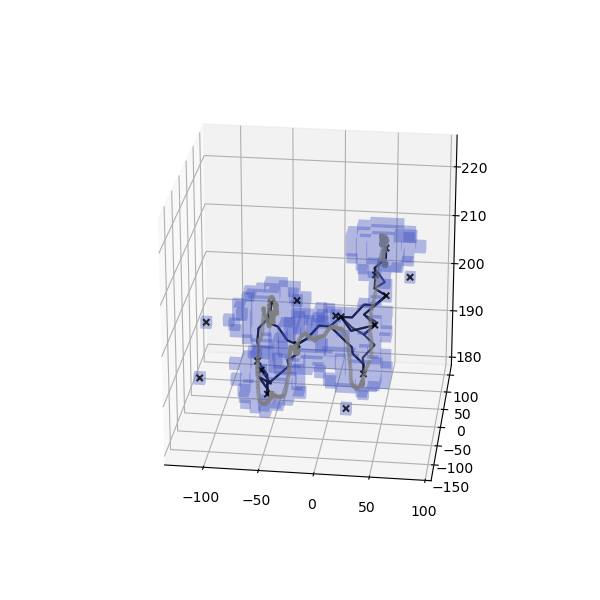

In [16]:
plt.figure(figsize = (6, 6))
pltclouds.draw_cloud(cells, bins, df);
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.5, c = 'gray');

## MC 

In [17]:
dft = mcclouds.mctrue(bins, mask, cells, df, mccoors, mcene, mctime)
dft = mcclouds.mcextreme(bins, mask, cells, df)

number of true cells  73 73 73


In [18]:
np.sum(dft.mceneextr.values >0)

13

## All nodes

<IPython.core.display.Javascript object>


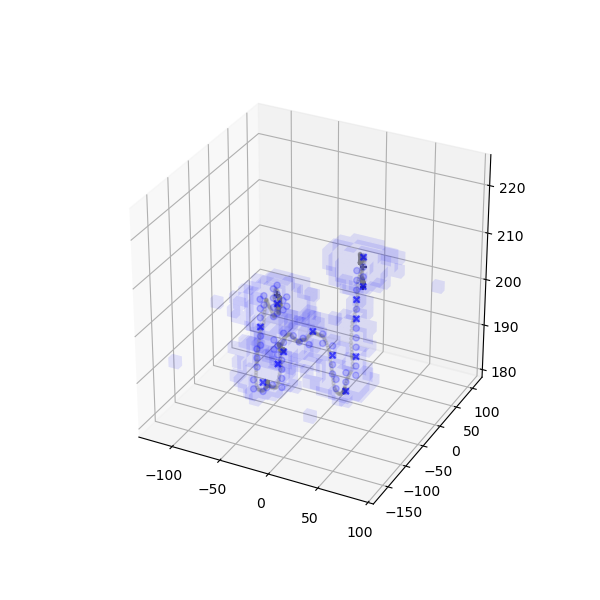

In [19]:
cells_select = clouds.cells_select
plt.figure(figsize = (6, 6))
pltclouds.draw_voxels(bins, mask, cells, alpha = 0.05);
istrue = dft.ismc.values
plt.gca().scatter(*cells_select(cells, istrue), marker = 'o', alpha = 0.2);
eisext = dft.mceneextr.values > 0
plt.gca().scatter(*cells_select(cells, eisext), marker = 'x', alpha = 0.6, c = 'blue');
eisext = dft.mctimeextr.values > 0
plt.gca().scatter(*cells_select(cells, eisext), marker = '+', alpha = 0.6, c = 'black');
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.2, c = 'gray');

## Nodes with 1 degree

In [20]:
for name in ('mceneextr', 'mctimeextr'):
    vals = dft[name].values
    print(name[:5], ' nodes total  ', np.sum(vals > 0))
    print(name[:5], ' nodes iso    ', np.sum(vals == 0))
    print(name[:5], ' nodes single ', np.sum(vals == 1))
    print(name[:5], ' nodes chain  ', np.sum(vals >  1))

mcene  nodes total   13
mcene  nodes iso     0
mcene  nodes single  2
mcene  nodes chain   11
mctim  nodes total   3
mctim  nodes iso     0
mctim  nodes single  2
mctim  nodes chain   1


<IPython.core.display.Javascript object>


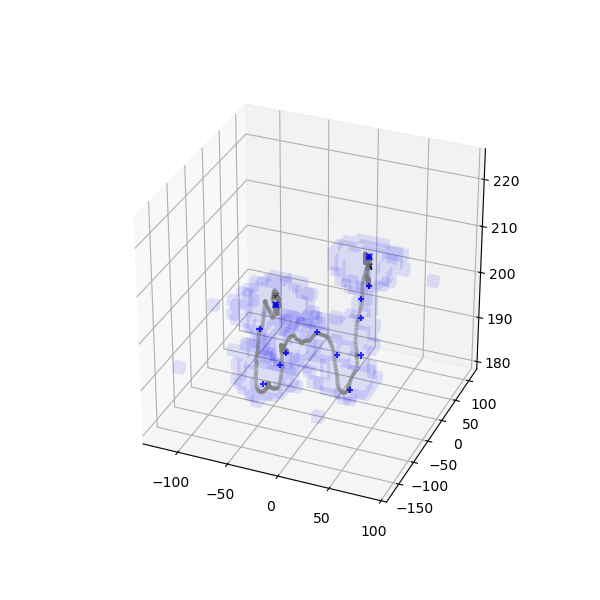

In [21]:
cells_select = clouds.cells_select
plt.figure(figsize = (6, 6))
pltclouds.draw_voxels(bins, mask, cells, alpha = 0.05);
for k, name in enumerate(('mcene', 'mctime')):
    vals = dft[name+'extr'].values
    for i, isel in enumerate((vals >= 0, vals == 1)):
        c  = 'blue' if k == 0 else 'black'
        mk = '+'    if i == 0 else 'x' 
        plt.gca().scatter(*cells_select(cells, isel), marker = mk, alpha = 0.8, c = c);
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.4, c = 'gray');

## Properties of the extremes

<IPython.core.display.Javascript object>


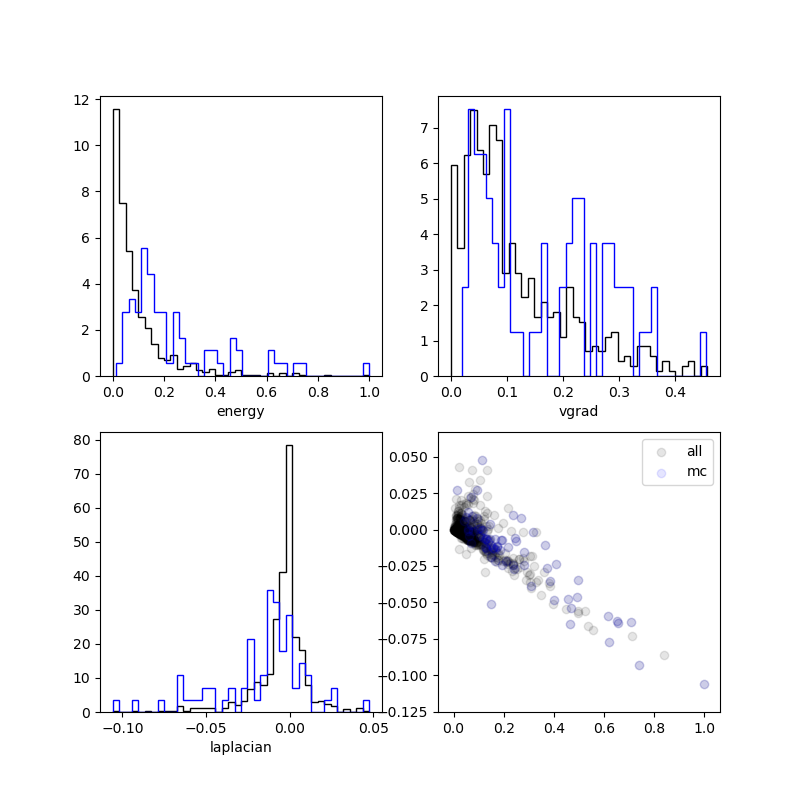

In [22]:
isall   = dft.ismc      .values >= 0
ismc    = dft.ismc      .values
isxextr = dft.mceneextr .values > 0
istextr = dft.mctimeextr.values > 0

plt.figure(figsize = (8, 8));

nbins   = 40
density = True
for isel, name in zip([isall, ismc], ('all', 'mc', 'xextr', 'textr')):
    plt.subplot(2, 2, 1)
    plt.hist(dft.energy[isel], nbins, label = name, density = density, histtype = 'step');
    plt.xlabel('energy')
    plt.subplot(2, 2, 2)
    plt.hist(dft.vgrad[isel], nbins, label = name, density = density, histtype = 'step');
    plt.xlabel('vgrad')
    plt.subplot(2, 2, 3)
    plt.hist(dft.laplacian[isel], nbins, label = name, density = density, histtype = 'step')
    plt.xlabel('laplacian')
    plt.subplot(2, 2, 4)
    plt.scatter(dft.energy[isel], dft.laplacian[isel], alpha = 0.1, label = name)
plt.legend()

<IPython.core.display.Javascript object>


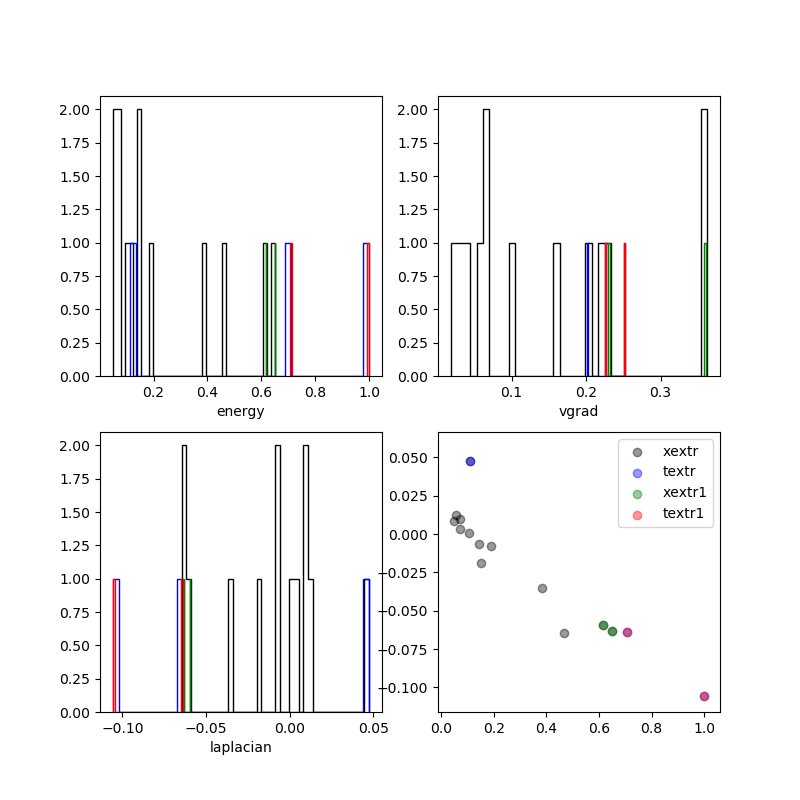

In [23]:
isxextr  = dft.mceneextr .values  >=0
istextr  = dft.mctimeextr.values  >=0
isxextr1 = dft.mceneextr .values  == 1
istextr1 = dft.mctimeextr.values  == 1

plt.figure(figsize = (8, 8));

nbins   = 40
density = False
for isel, name in zip([isxextr, istextr, isxextr1, istextr1], ('xextr', 'textr', 'xextr1', 'textr1')):
    if (np.sum(isel) <= 0): continue
    plt.subplot(2, 2, 1)
    plt.hist(dft.energy[isel], nbins, label = name, density = density, histtype = 'step');
    plt.xlabel('energy')
    plt.subplot(2, 2, 2)
    plt.hist(dft.vgrad[isel], nbins, label = name, density = density, histtype = 'step');
    plt.xlabel('vgrad')
    plt.subplot(2, 2, 3)
    plt.hist(dft.laplacian[isel], nbins, label = name, density = density, histtype = 'step')
    plt.xlabel('laplacian')
    plt.subplot(2, 2, 4)
    plt.scatter(dft.energy[isel], dft.laplacian[isel], alpha = 0.4, label = name)
plt.legend()